In [19]:
import pyro
import torch
from chirho.dynamical.ops import State, simulate
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.handlers import LogTrajectory

class SimpleSIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    @pyro.nn.pyro_method
    def diff(self, dstate: State[torch.Tensor], state: State[torch.Tensor]) -> None:
        dstate["S"] = -self.beta * state["S"] * state["I"]
        dstate["I"] = self.beta * state["S"] * state["I"] - self.gamma * state["I"]
        dstate["R"] = self.gamma * state["I"] # torch.roll

    def forward(self, state: State[torch.Tensor]):
        dstate = State()
        self.diff(dstate, state)
        return dstate

model = SimpleSIRDynamics(torch.tensor(0.5), torch.tensor(.01))
initial_state = State(S=torch.tensor(0.99), I=torch.tensor(0.01), R=torch.tensor(0.0))
start_time = torch.tensor(0.0)
end_time = torch.tensor(100.0)
step_size = torch.tensor(0.1)
trajectory_times = torch.arange(start_time+step_size, end_time, step_size)


with LogTrajectory(trajectory_times) as lt:
    final_state = simulate(model, initial_state, start_time, end_time, solver=TorchDiffEq())

trajectory = lt.trajectory

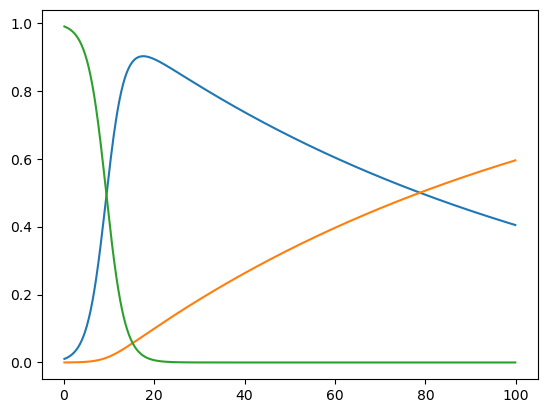

In [20]:
import matplotlib.pyplot as plt
plt.plot(trajectory_times, trajectory['I'])
plt.plot(trajectory_times, trajectory['R'])
plt.plot(trajectory_times, trajectory['S'])
# trajectory['I']